<a href="https://colab.research.google.com/github/bsshreesha/Physics_Informed_Neural_Network/blob/main/M.Tech%20Project/Basic_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 0.534932
Epoch 500, Loss: 0.002485
Epoch 1000, Loss: 0.000791
Epoch 1500, Loss: 0.000372
Epoch 2000, Loss: 0.000198
Epoch 2500, Loss: 0.000102

🔍 Relative L2 Error: 0.007101


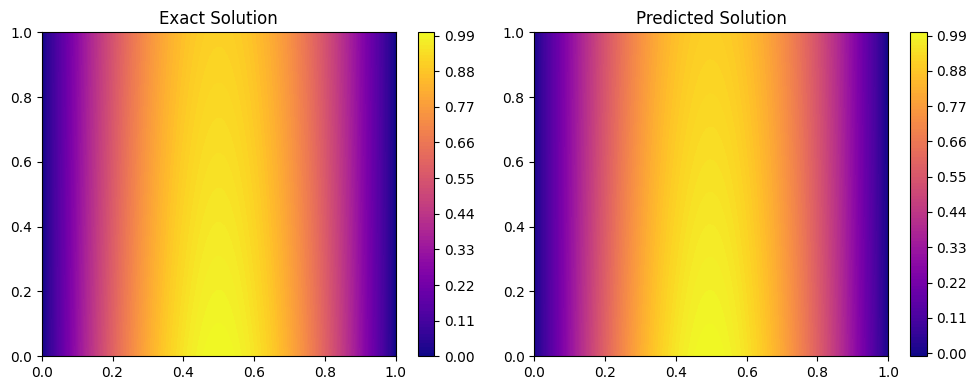

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Enable float64 for better precision
tf.keras.backend.set_floatx('float64')

# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(width, activation='tanh') for width in layers[:-1]]
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, x):
        z = x
        for layer in self.hidden_layers:
            z = layer(z)
        return self.output_layer(z)

# Define PDE residual (example: 1D heat equation: u_t = α u_xx)
def pde_residual(model, x, t, α=1.0):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            u = model(tf.concat([x, t], axis=1))
        u_x = tape1.gradient(u, x)
        u_t = tape1.gradient(u, t)
    u_xx = tape2.gradient(u_x, x)
    del tape1, tape2
    return u_t - α * u_xx  # For higher-order terms, compute more gradients

# Loss: boundary + initial + physics
def compute_loss(model, X_b, u_b, X_i, u_i, X_f, α):
    u_b_pred = model(X_b)
    u_i_pred = model(X_i)
    res_f = pde_residual(model, X_f[:, 0:1], X_f[:, 1:2], α)
    loss = tf.reduce_mean(tf.square(u_b_pred - u_b)) + \
           tf.reduce_mean(tf.square(u_i_pred - u_i)) + \
           tf.reduce_mean(tf.square(res_f))
    return loss

# Training loop
def train(model, X_b, u_b, X_i, u_i, X_f, α=1.0, epochs=5000, lr=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, X_b, u_b, X_i, u_i, X_f, α)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

# Data generation for 1D heat equation
def generate_training_data():
    N_b = 50  # Boundary
    N_i = 50  # Initial
    N_f = 1000  # Collocation points

    x_b = np.vstack((np.zeros((N_b, 1)), np.ones((N_b, 1))))
    t_b = np.random.uniform(0, 1, (2*N_b, 1))
    X_b = np.hstack((x_b, t_b))
    u_b = np.zeros_like(x_b)

    x_i = np.random.uniform(0, 1, (N_i, 1))
    t_i = np.zeros((N_i, 1))
    u_i = np.sin(np.pi * x_i)
    X_i = np.hstack((x_i, t_i))

    x_f = np.random.uniform(0, 1, (N_f, 1))
    t_f = np.random.uniform(0, 1, (N_f, 1))
    X_f = np.hstack((x_f, t_f))

    return map(lambda arr: tf.convert_to_tensor(arr, dtype=tf.float64), [X_b, u_b, X_i, u_i, X_f])

# Evaluate model against known exact solution
def evaluate_model(model, α=0.01):
    x_test = np.linspace(0, 1, 100).reshape(-1, 1)
    t_test = np.linspace(0, 1, 100).reshape(-1, 1)
    x_grid, t_grid = np.meshgrid(x_test, t_test)
    x_flat = x_grid.flatten().reshape(-1, 1)
    t_flat = t_grid.flatten().reshape(-1, 1)
    X_test = tf.convert_to_tensor(np.hstack([x_flat, t_flat]), dtype=tf.float64)

    u_pred = model(X_test).numpy().flatten()
    u_exact = np.exp(-α * np.pi**2 * t_flat.flatten()) * np.sin(np.pi * x_flat.flatten())

    error_l2 = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
    print(f"\n🔍 Relative L2 Error: {error_l2:.6f}")

    return x_grid, t_grid, u_pred.reshape(100, 100), u_exact.reshape(100, 100)

# Visualize predictions and exact solution
def visualize(x_grid, t_grid, u_pred, u_exact):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.contourf(x_grid, t_grid, u_exact, 100, cmap='plasma')
    plt.title("Exact Solution")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.contourf(x_grid, t_grid, u_pred, 100, cmap='plasma')
    plt.title("Predicted Solution")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Main execution
layers = [2, 64, 64, 64, 1]
model = PINN(layers)
X_b, u_b, X_i, u_i, X_f = generate_training_data()
train(model, X_b, u_b, X_i, u_i, X_f, α=0.01, epochs=3000)
x_grid, t_grid, u_pred, u_exact = evaluate_model(model, α=0.01)
visualize(x_grid, t_grid, u_pred, u_exact)